In [53]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# MLP Character-Level Language Model

In [54]:
words = open("names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [55]:
chars = sorted(list(set("".join(words))))
stoi = {s: i for i, s in enumerate(chars, start=1)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

We can build out a **context window** to predict the next character. In this example, the previous 3 characters are used to predict a new character.

In [56]:
block_size = 3  # Context length: how many chars we take to predict the next one
X, Y = [], []
for w in words:
    print(w)
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print("".join(itos[i] for i in context), "--->", itos[ix])
        context = context[1:] + [ix]  # Rolling window of context

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
olivia
ava
isabella
sophia
charlotte
mia
amelia
harper
evelyn
abigail
emily
elizabeth
mila
ella
avery
sofia
camila
aria
scarlett
victoria
madison
luna
grace
chloe
penelope
layla
riley
zoey
nora
lily
eleanor
hannah
lillian
addison
aubrey
ellie
stella
natalie
zoe
leah
hazel
violet
aurora
savannah
audrey
brooklyn
bella
claire
skylar
lucy
paisley
everly
anna
caroline
nova
genesis
emilia
kennedy
samantha
maya
willow
kinsley
naomi
aaliyah
elena
sarah
ariana
allison
gabriella
alice
madelyn
cora
ruby
eva
serenity
autumn
adeline
hailey
gianna
valentina
isla
eliana
quinn
nevaeh
ivy
sadie
piper
lydia
alexa
josephine
emery
julia
delilah
arianna
vivian
kaylee
sophie
brielle
madeline
peyton
rylee
clara
hadley
melanie
mackenzie
reagan
adalynn
liliana
aubree
jade
katherine
isabelle
natalia
raelynn
maria
athena
ximena
arya
leilani
taylor
faith
rose
kylie
alexandra
mary
margaret
lyla
ashley
amaya
eliza
brianna
bailey
andrea
khloe
jasmine
melody
iris
isabel
norah
annabelle
valeria
emerson
adalyn
ryl

In [57]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [58]:
g = torch.Generator().manual_seed(1234)
C = torch.randn((27, 2), generator=g)  # Initializing the embedding table
C[5]

tensor([-0.7584, -0.3689])

From the previous part, we have an equivalent one-hot vector indexing. However, direct indexing is much faster.

In [59]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.7584, -0.3689])

In [60]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [61]:
W1 = torch.randn((6, 100))  # Number of inputs is equal to context size * embedding dim
b1 = torch.randn(100)
W1.shape, b1.shape

(torch.Size([6, 100]), torch.Size([100]))

In order to multiply the embedding matrix by the weights, we need to reshape the embeddings to be (32, 6). One of the ways shown in the video is using the `unbind()` function and removing the `dim=1`.

In [62]:
torch.cat(torch.unbind(emb, dim=1), dim=1).shape

torch.Size([228146, 6])

However, a more efficient way of doing this is using the `view()` method which will allow us to directly reshape the tensor. The reason this is efficient is because internally tensors are stored as 1-D arrays in memory. No memory is being changed, copied, or created and the storage is identical. When we call `view()` some of the internal attributes of the tensor (offset, stride, shape) are being modified to form the interpretation of the storage. In contrast, `cat()` creates new storage and consumes more memory.

In [63]:
a = torch.arange(18)
a.view(9, 2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [64]:
emb.view(-1, 6).shape

torch.Size([228146, 6])

In [65]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # Broadcasting: b1 (100,) => b1' (32, 100)
h.shape

torch.Size([228146, 100])

In part 1, we calculated the logits and softmaxed them to get the probabilities of the next character. We can do the same thing here and then use negative log-likelihood as our loss function.

In [66]:
W2 = torch.randn((100, 27)) # Another linear layer prior to softmax
b2 = torch.randn(27)

logits = h @ W2 + b2 # Linear layer produces the log counts (logits) prior to creating the probability distribution
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
probs[:5].sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [67]:
-probs[torch.arange(X.shape[0]), Y].log().mean() # Calculate negative log-likelihood

tensor(21.2512)

Putting it all together and using cross-entropy instead of negative log-likelihood. Cross-entropy will not create the intermediate tensors in memory and optimize the loss evaluations. Using cross-entropy will also make the backward pass simpler and provide more numerical stability.

In [68]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2

loss = F.cross_entropy(logits, Y)
loss

tensor(19.5052)

An example of the numerical stability:

In [69]:
a = torch.tensor([-100, -1, 0, 1000])
b = a.exp()  # Very high positive input values result in inf
b / b.sum()  # NaN values due to inf values

tensor([0., 0., 0., nan])

In [70]:
a = torch.tensor([-5, 3, 0, 10])
b = a - a.max()  # Internally, PyTorch will subtract the max value
b = b.exp()
print(b / b.sum())  # Normalization allows us to offset logits by a constant and get the same probabilities

# Without constant offset
b = a
b = b.exp()
print(b / b.sum())

tensor([3.0561e-07, 9.1101e-04, 4.5356e-05, 9.9904e-01])
tensor([3.0561e-07, 9.1101e-04, 4.5357e-05, 9.9904e-01])


In [71]:
epochs = 20
lr = -0.1

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn(100, generator=g, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

for _ in range(epochs):
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(f"Loss: {loss}")
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += lr * p.grad

Loss: 19.505229949951172
Loss: 17.084489822387695
Loss: 15.776532173156738
Loss: 14.833345413208008
Loss: 14.002609252929688
Loss: 13.253265380859375
Loss: 12.57992172241211
Loss: 11.983107566833496
Loss: 11.470499992370605
Loss: 11.051864624023438
Loss: 10.709595680236816
Loss: 10.407641410827637
Loss: 10.127817153930664
Loss: 9.864375114440918
Loss: 9.614513397216797
Loss: 9.376447677612305
Loss: 9.148953437805176
Loss: 8.931118965148926
Loss: 8.722238540649414
Loss: 8.521757125854492


With the full dataset, training takes some time. Instead, we can create mini-batches, randomly selecting portions of the data.

In [72]:
torch.randint(0, X.shape[0], (32,))

tensor([126361,  23911,  59531, 222392,  52097, 174840,  78557,  96686,  50748,
         38360, 113311,  99056, 154153,  31652,  94367,  78281, 127497, 137261,
        169279, 103986,  85359, 195665, 101277,  99354,  48943, 184329, 148729,
         27865, 121407, 212551, 117808, 211167])

In [73]:
iters = 1000
lr = -0.001

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn(100, generator=g, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

for _ in range(iters):
    ix = torch.randint(0, X.shape[0], (32,)) # Construct mini-batch

    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(f"Loss: {loss.item()}")
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += lr * p.grad

Loss: 19.769550323486328
Loss: 21.951194763183594
Loss: 18.028650283813477
Loss: 21.28069496154785
Loss: 20.751510620117188
Loss: 19.826196670532227
Loss: 18.167377471923828
Loss: 21.624711990356445
Loss: 20.182214736938477
Loss: 18.481046676635742
Loss: 17.73416519165039
Loss: 18.139591217041016
Loss: 19.96055030822754
Loss: 16.372419357299805
Loss: 20.72665786743164
Loss: 19.668317794799805
Loss: 16.705297470092773
Loss: 18.697463989257812
Loss: 18.65119743347168
Loss: 17.48978042602539
Loss: 18.62000846862793
Loss: 19.98822021484375
Loss: 16.911489486694336
Loss: 21.485727310180664
Loss: 18.05171012878418
Loss: 20.270366668701172
Loss: 21.177099227905273
Loss: 18.018877029418945
Loss: 16.932392120361328
Loss: 17.035484313964844
Loss: 21.707088470458984
Loss: 20.141115188598633
Loss: 18.096712112426758
Loss: 21.191448211669922
Loss: 20.747468948364258
Loss: 21.68767547607422
Loss: 20.132774353027344
Loss: 22.578231811523438
Loss: 16.2917423248291
Loss: 22.531435012817383
Loss: 17.922

In [74]:
# Total loss
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(10.7257, grad_fn=<NllLossBackward0>)

## Finding a Good Learning Rate

To find an initial learning rate, we can test a linear range of the exponents of learning rates from min. LR to max. LR.

In [75]:
# Previously we found that the min-LR was -0.001 and max-LR was 1
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [76]:
iters = 1000
lri, lossi = [], []

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn(100, generator=g, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

for i in range(iters):
    ix = torch.randint(0, X.shape[0], (32,))  # Construct mini-batch

    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(f"Loss: {loss.item()}")

    for p in parameters:
        p.grad = None

    loss.backward()
    lr = lrs[i]

    for p in parameters:
        p.data += -lr * p.grad

    lri.append(lr)
    lossi.append(loss.item())

Loss: 19.58011817932129
Loss: 20.513965606689453
Loss: 18.557825088500977
Loss: 18.023509979248047
Loss: 15.013452529907227
Loss: 17.575305938720703
Loss: 17.813156127929688
Loss: 17.468839645385742
Loss: 16.926034927368164
Loss: 19.074419021606445
Loss: 18.384098052978516
Loss: 18.361202239990234
Loss: 16.147472381591797
Loss: 19.170942306518555
Loss: 18.244707107543945
Loss: 17.923763275146484
Loss: 20.207006454467773
Loss: 17.48919105529785
Loss: 19.977678298950195
Loss: 17.36390495300293
Loss: 16.382099151611328
Loss: 18.41160011291504
Loss: 16.999834060668945
Loss: 18.656644821166992
Loss: 17.969770431518555
Loss: 19.89723014831543
Loss: 19.38870620727539
Loss: 18.573158264160156
Loss: 16.538747787475586
Loss: 16.341552734375
Loss: 14.942530632019043
Loss: 15.65355110168457
Loss: 18.92856216430664
Loss: 20.401409149169922
Loss: 19.312753677368164
Loss: 18.26517677307129
Loss: 18.789548873901367
Loss: 16.252777099609375
Loss: 20.08692169189453
Loss: 17.544662475585938
Loss: 19.1844

When we plot the exponent of the learning rate and the loss at that learning rate, a valley emerges. In the valley, we expect a fairly good learning rate setting.

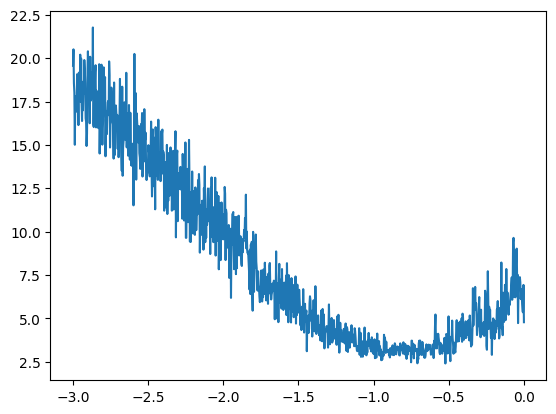

In [77]:
plt.plot(lre, lossi)

## Train/Valid/Test Splits

### Helper Functions

In [78]:
import random


def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X, Y = torch.tensor(X), torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### Retraining Using Splits

In [79]:
# With train set we found max-LR to be 1 and min-LR to be 0.001
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [80]:
iters = 10000
# lri, lossi = [], []
lossi = []

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn(100, generator=g, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

for i in range(iters):
    ix = torch.randint(0, X_train.shape[0], (32,))  # Construct mini-batch

    emb = C[X_train[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_train[ix])
    lossi.append(loss.item())
    # print(f"Loss: {loss.item()}")

    for p in parameters:
        p.grad = None

    loss.backward()
    # lr = lrs[i]
    lr = 0.1

    for p in parameters:
        p.data += -lr * p.grad

    # lri.append(lr)
    # lossi.append(loss.item())

2.462602138519287

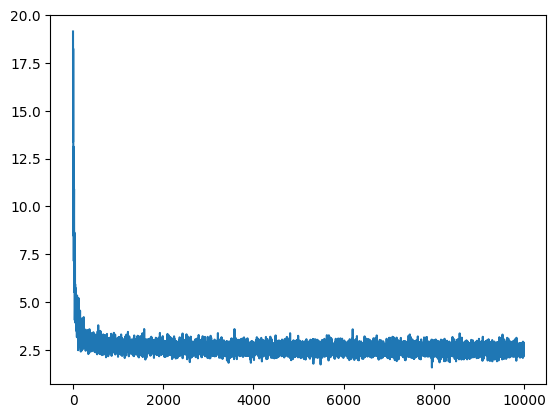

In [81]:
plt.plot(range(0, iters), lossi)
lossi[-1]

In [82]:
emb = C[X_val]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_val)
loss

tensor(2.4986, grad_fn=<NllLossBackward0>)

Training and valid loss is approximately equal so the model is underfitting. The network is very small so we may expect to make improvements by scaling up.

In [83]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

10281

In [84]:
stepi, lossi = [], []

for i in range(70000):
    ix = torch.randint(0, X_train.shape[0], size=(32,))
    emb = C[X_train[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_train[ix])

    for p in parameters:
        p.grad = None

    loss.backward()
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    stepi.append(i)
    lossi.append(loss.item())

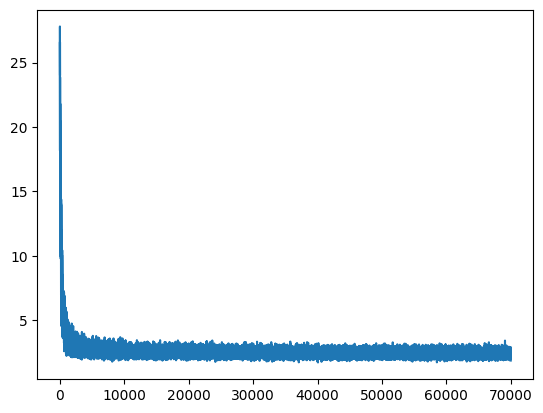

In [85]:
plt.plot(stepi, lossi)

In [86]:
# Evaluating the train and valid losses again
emb = C[X_train]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
loss

tensor(2.4238, grad_fn=<NllLossBackward0>)

In [87]:
emb = C[X_val]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1 )
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_val)
loss

tensor(2.4208, grad_fn=<NllLossBackward0>)

Not much improvement, but the bottleneck could be the embedding dimension size.

## Visualizing Embeddings

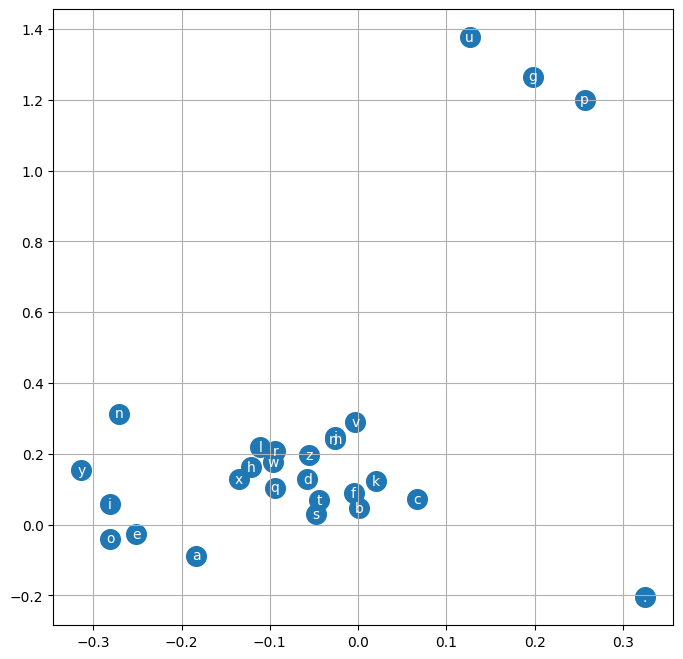

In [88]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

Note that after tuning the weights, the vowels tend to cluster together. The embeddings for these characters are very similar. "q" is far off on the grid and has a more "distinct" embedding from the other characters as well as the character "."

## Increasing Embedding Dimension

In [89]:
%%script false --no-raise-error

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g) # Increasing embedding dim to 10
W1 = torch.randn((30, 200), generator=g) # With block size 3, the weight matrix will receive (32, 3 * 10) tensors
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

In [90]:
%%script false --no-raise-error

stepi, lossi = [], []

for i in range(100_000):
    ix = torch.randint(0, X_train.shape[0], size=(32,))
    emb = C[X_train[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # Adjusting the view due to modified embedding dim
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_train[ix])

    for p in parameters:
        p.grad = None

    loss.backward()
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    stepi.append(i)
    lossi.append(loss.log10().item()) # Using log-loss instead for easier visual

In [91]:
%%script false --no-raise-error
plt.plot(stepi, lossi)

In [92]:
%%script false --no-raise-error
emb = C[X_train]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
loss

In [93]:
%%script false --no-raise-error
emb = C[X_val]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_val)
loss

Now the training loss is gradually beginning to diverge from the valid loss. In a production setting, we would create hyperparameters that we want to monitor and run many different experiments evaluating the performance on the validation set. Once we find the hyperparameters that make our valid performance "good" we would take the model and evaluate it on the test set **a single time**.

In this setting, there are a few different hyperparameters we could continue to experiment on: embedding dim, block size, hidden layer size, learning rate, number of iterations, batch size.

# Sampling from the Model

In [94]:
%%script false --no-raise-error

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(80):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(itos[i] for i in out))  

# Exercises

## E01: Tuning the Hyperparameters

>   Tune the hyperparameters of the training to beat my bast validation loss of 2.2

In [107]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 20), generator=g) # Increasing embedding dim to 20
W1 = torch.randn((60, 200), generator=g) # With block size 3, the weight matrix will receive (32, 3 * 20) tensors
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

18167

In [112]:
stepi, lossi = [], []

for i in range(10_000): # Increase number of iters to 80_000, train with additional 10_000 iters after reducing LR
    ix = torch.randint(0, X_train.shape[0], size=(64,)) # Increased batch size to 64
    emb = C[X_train[ix]]
    h = torch.tanh(emb.view(-1, 60) @ W1 + b1) # Adjusting the view due to modified embedding dim
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_train[ix])

    for p in parameters:
        p.grad = None

    loss.backward()
    lr = 0.01 # Set initial LR to 0.1, then train 10_000 more iters at 0.01
    for p in parameters:
        p.data += -lr * p.grad

    stepi.append(i)
    lossi.append(loss.log10().item()) # Using log-loss instead for easier visual

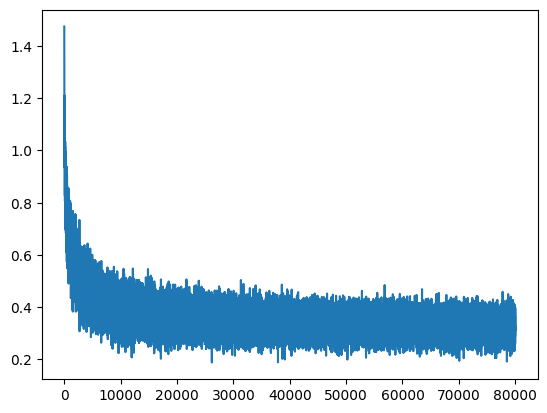

In [109]:
plt.plot(stepi, lossi)

In [119]:
emb = C[X_val]
h = torch.tanh(emb.view(-1, 60) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_val)
loss

tensor(2.1491, grad_fn=<NllLossBackward0>)

In [120]:
emb = C[X_train]
h = torch.tanh(emb.view(-1, 60) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
loss

tensor(2.0747, grad_fn=<NllLossBackward0>)